# Что же такое Logit Lens

Простыми словами это способ заглянуть внутрь трансформеров и посомтреть, какие представления строит модель на разных слоях, перед тем, как выдать прогноз.

Обычно, в трансформерах последний слой проходит через линейную проекцию (то есть, матрицу весов) и softmax, чтобы получить вероятности слов. `Logit Lens` использует тот же линейный слой, но применяет его к промежуточным слоям модели, чтобы увидеть, какие слова `"угадывались"` на каждом этапе.

## Зачем нам это?
Внутренние представления нейросетей трудно интерпретировать, поэтому Logit Lens позволяет:

1. Понять, что модель знает на каждом слое. Например, если модель достаточно уверенна в правильном слове уже на середине своих слоёв, то дальние слои не так важны для этого слова.
2. Проанализировать, как трансформеры пошагово строят прогноз.
Если на ранних слоях угадываются только общие категории слов, а на поздних — конкретные слова, значит, модель сначала "понимает смысл", а потом уточняет детали.
3. Выявить аномалии в предсказаниях.
Иногда на ранних слоях видно, что модель делает неожиданные предположения, которые в конце исчезают. Это может помочь в анализе ошибок модели.


## Как работает Logit Lens

Допустим, у нас есть предложение:

$ \text{The cat sat on the `mat`} $

Где `mat` — правильное слово, предсказанное моделью и полученное на последнем слое после линейного классификатора и softmax.

Logit Lens же берёт выходы с разных слоёв и пропускает через тот же лин. классификатор. Это позволяет посмотреть какие слова предсказываются на каждом слое.

Пример:

- 1-й слой: "The cat sat on the floor." (Модель пока что делает грубый прогноз.)
- 3-й слой: "The cat sat on the ground." (Начинает приближаться к правильному слову.)
- `6-й слой`: "The cat sat on the mat." (Правильное слово уже появилось!)
- 12-й (последний) слой: "The cat sat on the mat." (Окончательный выбор, теперь с высокой уверенностью.)

In [1]:
# !pip uninstall -y fsspec gcsfs datasets
!pip install datasets gcsfs -q
!pip install transformer_lens -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==

In [2]:
!pip install transformers accelerate torch torchvision -q


Загрузим модель

In [16]:
import random
from datasets import load_dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
from datasets import load_dataset

In [6]:
model_name = "HuggingFaceTB/SmolVLM-500M-Base"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForImageTextToText.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.53M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


config.json:   0%|          | 0.00/7.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

# Загрузим датасет

In [7]:
dataset = load_dataset("nlphuji/flickr30k")

README.md:   0%|          | 0.00/641 [00:00<?, ?B/s]

flickr30k.py:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

0004.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

0005.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0006.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

0008.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

Caption: ['A black dog carries a green toy in his mouth as he walks through the grass.', 'A wet black dog is carrying a green toy through the grass.', 'A black dog carrying something through the grass.', 'A dog in grass with a blue item in his mouth.', 'A black dog has a blue toy in its mouth.']


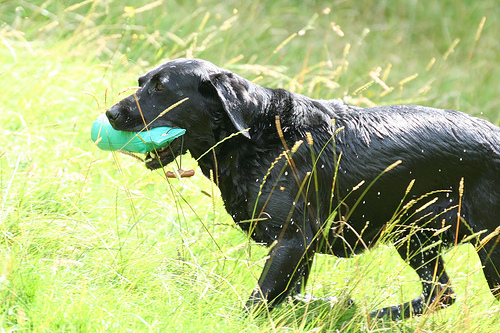

In [35]:
# Выбираем случайный индекс
idx = 90 #random.randint(0, len(dataset) - 1)

# Извлекаем изображение и подпись
image = dataset["test"][idx]["image"]  # Уже в формате PIL.Image
caption = dataset["test"][idx]["caption"]

# Показываем изображение
image.show()

# Выводим подпись
print("Caption:", caption)
image

In [36]:
# Формируем входные данные с осмысленным вопросом
messages = [{"role": "user", "content": "<image>"}]

# Подготавливаем данные для модели
inputs = processor(text=messages[0]["content"], images=[image], return_tensors="pt")

# Генерируем ответ модели
output = model.generate(**inputs)
response = processor.batch_decode(output, skip_special_tokens=True)

# Выводим результат
print("Model response:", response)

Model response: ['\n\n\n\nA dog playing with a frisbee in the grass']


# Пробуем завести transformer_lens

In [37]:
from transformer_lens import HookedTransformer

try:
    hooked_model = HookedTransformer.from_pretrained(model_name)
except Exception as e:
    print("Ошибка при загрузке модели через HookedTransformer:", e)
    # Альтернативный вариант: анализировать только текстовую часть, если возможно


Ошибка при загрузке модели через HookedTransformer: HuggingFaceTB/SmolVLM-500M-Base not found. Valid official model names (excl aliases): ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'distilgpt2', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', 'stanford-crfm/alias-gpt2-small-x21', 'stanford-crfm/battlestar-gpt2-small-x49', 'stanford-crfm/caprica-gpt2-small-x81', 'stanford-crfm/darkmatter-gpt2-small-x343', 'stanford-crfm/expanse-gpt2-small-x777', 'stanford-crfm/arwen-gpt2-medium-x21', 'stanford-crfm/beren-gpt2-medium-x49', 'stanford-crfm/celebrimbor-gpt2-medium-x81', 'stanford-crfm/durin-gpt2-medium-x343', 'stanford-crfm/eowyn-gpt2-medium-x777', 'EleutherAI/pythia-14m', 'EleutherAI/pythia-31m', 'EleutherAI/pythia-70m', 'EleutherAI/pythia-160m', 'EleutherAI/py

In [3]:
import transformer_lens

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

# Run the model and get logits and activations
logits, activations = model.run_with_cache("Hello World")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# Qween

In [ ]:
# 4. Загружаем датасет (например, Flickr30k)
dataset = load_dataset("nlphuji/flickr30k")


A young boy wearing a bathing suit and rash guard runs into the ocean as the waves bubble up on the shore.


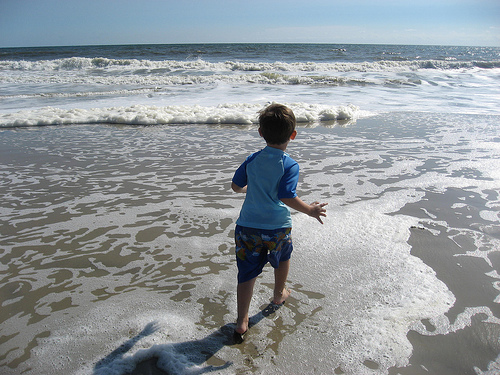

In [10]:
# Выбираем случайное изображение из test split
idx = random.randint(0, len(dataset["test"]) - 1)
sample = dataset["test"][idx]
image = sample["image"]  # объект PIL.Image
print( sample["caption"][0])
image

In [ ]:
from transformers import pipeline
from PIL import Image
import requests
from io import BytesIO


model_name = "Qwen/Qwen2-VL-2B-Instruct"
pipe = pipeline("image-text-to-text", model=model_name)

# Передаем данные в виде словаря с ключами "text" и "images"
input_data = {"text": "Who are you?", "images": image}
print("Pipeline response:", pipe(input_data))
